### Gaussian Process Regression

Here we try to understand how Gaussian Process Regression works using a simple example. Understanding through visualization provide us more insights. Here we visualize the prior & posterior distributions and different samples drawn from them. We use few training points for a better visualization. 


### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Generate Data

In [2]:
def f(x, sigma = 0.0):
    
    epsilon = np.random.normal(0, 0.1)
    return np.sin(x) #+ epsilon

def dataset(x_range = [-5,5], interval = 0.2, n_train = 8):
    
    a, b = x_range
    x_vals = np.arange(a, b, interval)
    y_vals = [f(x) for x in x_vals]
    data = list(zip(x_vals, y_vals))
    
    train_choices = sorted(np.random.choice(list(range(len(x_vals))), n_train, replace = False))
    train_data = [data[i] for i in train_choices]
    
    return train_data, data

Training points are included in the test data points to get a better idea of the GPR.

In [3]:
train_dataset, test_dataset = dataset()

In [4]:
X_train, Y_train = np.array(list(zip(*train_dataset)))
X_test, Y_test = np.array(list(zip(*test_dataset)))

In [5]:
# all_data, train_data, test_data = dataset()
# X_train, Y_train = np.array(list(zip(*train_data)))
# X_test, Y_test =  np.array(list(zip(*test_data)))
# X_test = np.arange(-5, 5, 0.2).reshape(-1, 1)
# X_train = np.array([-4, -2, -1, 1]).reshape(-1, 1)
# Y_train = np.sin(X_train)
# X_all, Y_all = np.array(list(zip(*all_data)))

In [6]:
print("Train Size : {}, All Data Points : {}".format(len(X_train), len(X_test)))

Train Size : 8, All Data Points : 50


### Plot data

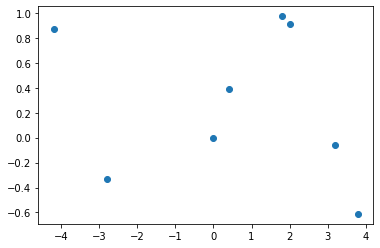

In [7]:
plt.scatter(X_train, Y_train)

### Kernel

In [8]:
## Kerenl Function 1
def kernel_x1x2(x1, x2, l=1.0, sigma_f=1.0):
    
    fac = np.dot((x1 - x2), (x1 - x2))
    return sigma_f**2 * np.exp(-0.5 / l**2 * fac)

def kernel_fn1(X1, X2):

    cov = np.zeros((X1.shape[0], X2.shape[0]))
    for i in range(X1.shape[0]):
        
        for j in range(X2.shape[0]):
            
            cov[i,j] = kernel_x1x2(X1[i], X2[j].T)
    
    return cov


## Kernel Function 2 (More Efficient)
## t(x_i - x_j) * (x_i - x_j) = t(x_i)*x_i + t(x_j)*x_j + t(x_i)*x_j
def kernel_fn2(X1, X2, sigma_f = 1, l = 1):
    
    dist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * dist)

### Prior Distribution

In [9]:
## Without using any information from the available train data
def prior_params(X):
    
    mu_prior = np.zeros(X.shape)
    cov_prior = kernel_fn2(X, X)
    
    return mu_prior, cov_prior

### Function for plotting GP

In [10]:
def gp_plot(X, mu, cov, n_samples = 5, plot_mean = True, other_points = None, curve_plots = {}, size = (10, 5)):
    
    legend = []
    samples = np.random.multivariate_normal(mu.ravel(), cov, n_samples)
    plt.figure(figsize = size)

    for i in range(n_samples):

        plt.plot(X, samples[i], lw=1, ls='--',)
        legend.append("Sample {}".format(i+1))
    
    if plot_mean == True:
        
        plt.plot(X, mu)
        legend.append("Mean")
    
    if other_points != None:
        plt.scatter(other_points[0], other_points[1], marker='+')
        legend.append("Train data Points")
        
    if curve_plots != None:
        for key in curve_plots.keys():
            plt.plot(curve_plots[key][0], curve_plots[key][1])
            legend.append(key)
            
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    plt.fill_between(X.ravel(), mu.ravel() + uncertainty, mu.ravel() - uncertainty, alpha=0.1)
    legend.append("95% region")
    plt.legend(legend)

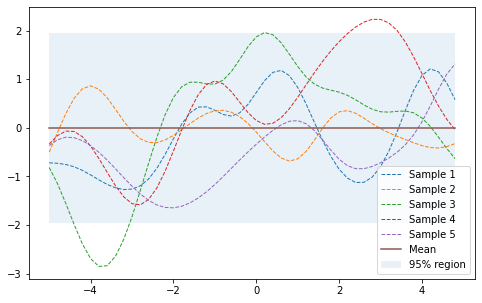

In [11]:
mu_prior, cov_prior = prior_params(X_test.reshape(-1, 1))
gp_plot(X_test, mu_prior, cov_prior, size = (8, 5))

### Posterior

In [12]:
kernel_args = {"sigma_f": 1, "l": 1}

def posterior_params(X_test, X_train, Y_train, kernel_args = {}):

    X_train, X_test = X_train.reshape(-1, 1), X_test.reshape(-1, 1) 
    K = kernel_fn1(X_train, X_train, **kernel_args) + 0.0001* np.eye(len(X_train)) ## With noise
    K_s = kernel_fn1(X_test, X_train, **kernel_args)
    K_ss = kernel_fn1(X_test, X_test, **kernel_args) + 0.0001 * np.eye(len(X_test))
    ## Gaussian parameters
    mu_post = K_s.dot(np.linalg.inv(K)).dot(Y_train)
    cov_post = K_ss - K_s.dot(np.linalg.inv(K)).dot(K_s.T)
    
    return mu_post, cov_post

In [13]:
mu_post, cov_post = posterior_params(X_test, X_train, Y_train)
print("Shape of Covariance matrix for the posterior distribution:",cov_post.shape)

Shape of Covariance matrix for the posterior distribution: (50, 50)


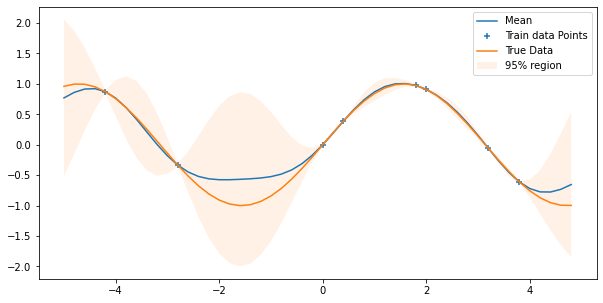

In [14]:
gp_plot(X_test, mu_post, cov_post, plot_mean = True, n_samples = 0, other_points = [X_train, Y_train], curve_plots = {"True Data" : [X_test, Y_test]})